In [1]:
!pip install musdb stempeg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.2/963.2 kB 15.3 MB/s eta 0:00:00


In [2]:
import musdb
import torch

mus = musdb.DB(download=True, subsets='train', root='musdb18hq')


100%|██████████| 140M/140M [00:01<00:00, 116MB/s]


In [3]:
import os
import ffmpeg
import torchaudio
import numpy as np
import math

n_fft = 2048
hop_length = 512

def wav2spec(wav):
    wavMono = wav.mean(-1)
    window = torch.hann_window(n_fft, device=wav.device)

    spec = torch.stft(wavMono, n_fft=n_fft, hop_length=hop_length, return_complex=True, center=True, window=window)
    return spec

def smooth_rolloff_mag(mag, sr=44100, n_fft=n_fft, cutoff_hz=15000, roll_width_hz=2000):
    # roll_width_hz: width of transition region above cutoff
    F = mag.shape[-2]
    freq_per_bin = sr / n_fft
    cutoff_bin = cutoff_hz / freq_per_bin
    roll_bins = max(1, int(roll_width_hz / freq_per_bin))
    # create 1D taper mask of length F
    mask = torch.ones(F, device=mag.device, dtype=mag.dtype)
    start = int(math.ceil(cutoff_bin))
    end = min(F-1, start + roll_bins)
    if start < F:
        # cosine taper from 1 -> 0 over [start, end]
        x = torch.linspace(0, math.pi/2, end - start + 1, device=mag.device)
        taper = torch.cos(x)  # cos(0)=1 -> cos(pi/2)=0
        mask[start:end+1] = taper
        if end+1 < F:
            mask[end+1:] = 0.0
    # reshape and apply
    mask = mask.view(*([1]*(mag.dim()-2)), F, 1)  # broadcast to (..., F, T)
    return mag * mask


def load_stem(path):  # remember to get phase too later
  streams = {}
  phase = {}

  for streamIndex, name in enumerate(['mix', 'vocals']):
    out_stream = (
        ffmpeg
        .input(path)
        .output('pipe:', format='f32le', ac=2, ar=44100, map=f'0:a:{streamIndex}')
    )

    out, err = ffmpeg.run(out_stream, capture_stdout=True, capture_stderr=True)
    audio = np.frombuffer(out, np.float32).reshape(-1, 2)

    spectrum = wav2spec(torch.from_numpy(audio))
    magnitude = spectrum.abs()
    #magnitude_rollOff = smooth_rolloff_mag(magnitude)

    # if name == 'mix':
    #   streams[name] = magnitude
    # else:
    #   streams[name] = magnitude_rollOff

    streams[name] = magnitude / (magnitude.max() + 1e-8)
    phase[name] = torch.angle(spectrum)

  return [streams, phase]

stems = load_stem("/content/musdb18hq/train/ANiMAL - Clinic A.stem.mp4")
spectrum_magnitude = stems[0]['mix']




/tmp/ipython-input-2168859055.py:53: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  spectrum = wav2spec(torch.from_numpy(audio))


Text(0, 0.5, 'Frequency bins')

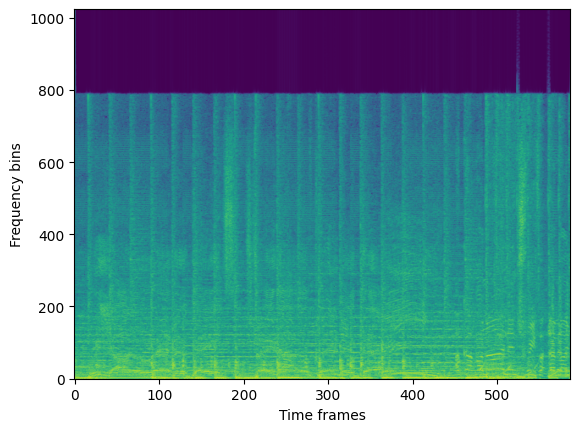

In [4]:
import matplotlib.pyplot as plt
plt.imshow(20*torch.log10(stems[0]["mix"].abs()+1e-6).numpy(), origin='lower', aspect='auto')
plt.xlabel('Time frames')
plt.ylabel('Frequency bins')

In [5]:
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader

class MUSDBStreamDataset(IterableDataset):
    def __init__(self, root_dir, split="train"):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.track_files = [
            os.path.join(self.split_dir, f)
            for f in os.listdir(self.split_dir)
            if f.endswith(".stem.mp4")
            ]
    def __iter__(self):
        for item in self.track_files:
            stems = load_stem(item)

            yield stems


# each batch contains [mix, vocals] as spectrographs
loader = DataLoader(MUSDBStreamDataset("/content/musdb18hq"), batch_size=1)
for i, batch in enumerate(loader):
#   #pass
  if i < 5:
    print(batch[0].keys())
    print(batch[0]['vocals'].shape)
    print(batch[0]['mix'].shape)
  else:
    break

dict_keys(['mix', 'vocals'])
torch.Size([1, 1025, 587])
torch.Size([1, 1025, 587])
dict_keys(['mix', 'vocals'])
torch.Size([1, 1025, 587])
torch.Size([1, 1025, 587])
dict_keys(['mix', 'vocals'])
torch.Size([1, 1025, 587])
torch.Size([1, 1025, 587])
dict_keys(['mix', 'vocals'])
torch.Size([1, 1025, 587])
torch.Size([1, 1025, 587])
dict_keys(['mix', 'vocals'])
torch.Size([1, 1025, 587])
torch.Size([1, 1025, 587])


In [6]:
import torch.nn as nn

class doubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)
      )

    def forward(self, x):
      return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[16, 32, 64, 128]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Encoder
        for f in features:
            self.encoder.append(
                doubleConv(in_channels, f)
            )
            in_channels = f

        self.bottleneck = nn.Sequential(
            doubleConv(features[-1], features[-1] * 2)
        )

        # Decoder
        for f in reversed(features):
            self.decoder.append(
                nn.Sequential(
                    nn.ConvTranspose2d(f * 2, f, kernel_size=2, stride=2),  # upsample
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(f * 2, f, kernel_size=3, padding=1),  # after concat
                    nn.BatchNorm2d(f),
                    nn.ReLU(inplace=True)
                )
            )
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        for enc in self.encoder:
            x = enc(x)
            skips.append(x)
            x = nn.functional.max_pool2d(x, 2)

        x = self.bottleneck(x)
        for dec in self.decoder:    # we slice decode layer operations 0:3 and 3:0 so we can concat the skip layer in between!
            x = dec[0:3](x)  # upsample part // note that this is in for dec in self.decoder - it is the current operation for number of features. i.e. conv > BN > RELU
            #print(dec[0:3])
            skip = skips.pop()
            x = nn.functional.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat((x, skip), dim=1)
            x = dec[3:](x)

        return self.final_conv(x)



In [7]:
x = torch.randn(1, 1, 1025, 587)
model = UNet(in_channels=1, out_channels=1)
y = model(x)
print(y.shape)
print(x.shape)


torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])


In [9]:
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("/content/UNET4_no_filt_L1.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
from torch.cuda.amp import autocast, GradScaler
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)
scaler = GradScaler()
criterion = torch.nn.L1Loss()

train_loader1 = DataLoader(MUSDBStreamDataset("/content/musdb18hq"), batch_size=1)
#for batch in train_loader1:
 # print(batch['mix'])

for epoch in range(50):
    model.train()
    running_loss = 0.0

    for i, stems in enumerate(train_loader1):
        # Extract only vocals from stems
        # stems might be a list of spectrograms or a stacked tensor
        # vocal = stems[0] if isinstance(stems, (list, tuple)) else stems

        mix = stems[0]['mix'].unsqueeze(1)
        vocal = stems[0]['vocals'].unsqueeze(1)
        # Move to GPU
        mix = mix.to(device)     # shape (B, 1, F, T)
        vocal = vocal.to(device) # shape (B, 1, F, T)

        # Forward
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            pred_mask = torch.sigmoid(model(mix))
            pred_vocal = pred_mask * mix
            loss = criterion(pred_vocal, vocal)

        # Backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        if i % 50 == 0:
            print(f"[{epoch:02d}/{i}] loss={loss.item():.4f}")

    print(f"Epoch {epoch}: avg_loss={running_loss/(i+1):.4f}")



AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
os.makedirs("/content/thisModel", exist_ok=True)
torch.save(model.state_dict(), "/content/thisModel/UNET3_mixFilt_L1.pth")


In [13]:
import soundfile as sf
import torchaudio

test_loader = DataLoader(MUSDBStreamDataset("/content/musdb18hq", split="test"), batch_size=1)
os.makedirs("/content/predictions_L1", exist_ok=True)

#from torchaudio.prototype.pipelines import HIFIGAN_VOCODER_V3_UNIVERSAL as bundle

#vocoder = bundle.get_vocoder().to("cpu").eval()
#sample_rate = bundle.sample_rate

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.eval()
for i, stems in enumerate(test_loader):
    mix = stems[0]['mix'].unsqueeze(1)
    vocal = stems[0]['vocals'].unsqueeze(1)
    # Move to GPU
    mix = mix.to(device)     # shape (B, 1, F, T)
    vocal = vocal.to(device) # shape (B, 1, F, T)

    vocalPhase = stems[1]['vocals'].to(device)
    mixPhase = stems[1]['mix'].to(device)

    # Forward
    sample_rate = 44100
    with torch.inference_mode():
        pred = model(mix)
        pred_vocal_mag = pred * mix
        pred_vocal_mag *= (pred_vocal_mag.max() + 1e-8)
        print(pred_vocal_mag.shape)

        # power_spec = torch.clamp(pred_vocal_mag, min=1e-9)

        # Convert magnitude spectrogram to Mel
        ''' Mel transform GAN reconstruction
        mel_transform = torchaudio.transforms.MelScale(n_mels=80, sample_rate=44100, n_stft=pred_vocal_mag.shape[-2]).to(device)
        mel = mel_transform(power_spec.squeeze(1)).to(device)
        mel = torch.log10(torch.clamp(mel, min=1e-9))  # safer log

        if i == 0:
          print(mel)
        with torch.no_grad():
          vocal_waveform = vocoder(mel)

        vocal_waveform = vocal_waveform.squeeze(0)  # Remove batch dimension
        vocal_waveform = vocal_waveform.transpose(0, 1) # Transpose to (frames, channels)
        vocal_waveform = vocal_waveform.squeeze(1)  # Remove channel dimension if it's 1
        vocal_waveform = vocal_waveform.clamp(-1.0, 1.0)
        '''

        vocal_complex = pred_vocal_mag * torch.exp(1j * mixPhase)
        vocal_waveform = torch.istft(vocal_complex.squeeze(1), n_fft=n_fft, hop_length=hop_length, window=torch.hann_window(n_fft, device=vocal_complex.device), center=True)
        #vocal_waveform[0].unsqueeze(1)

        # if i == 0:
        #   print(vocal_waveform)

        sf.write(f"/content/predictions_L1/pred_vocals{i}.wav",
                  vocal_waveform.cpu().float().T.numpy(), sample_rate) # soundfile - [frames, channels]
                  # vocal_waveform.cpu().float().numpy(), sample_rate) # for mel

        #mag = torch.sqrt((pred_vocal_mag.squeeze(1) ** 2).sum())
        #print(mag)

torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size([1, 1, 1025, 587])
torch.Size